# Convolutional Neural Networks

In [0]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [0]:
# option 1: MNIST
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
X_train = np.reshape(X_train, [-1, 28, 28, 1])/255.
X_test = np.reshape(X_test, [-1, 28, 28, 1])/255.

In [0]:
# option 2: CIFAR10
proportion_to_use = 0.3
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
Y_train = Y_train[0:int(np.shape(Y_train)[0]*proportion_to_use),0]
Y_test = Y_test[0:int(np.shape(Y_test)[0]*proportion_to_use),0]
X_train = X_train[0:int(np.shape(X_train)[0]*proportion_to_use),:]/255.
X_test = X_test[0:int(np.shape(X_test)[0]*proportion_to_use),:]/255.

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches


In [0]:
# create placeholders

def create_placeholders(n_H0, n_W0, n_C0):
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape=(None))
    
    return X, Y

In [0]:
# forward propagation

def forward_propagation(X):
    
    A1 = tf.layers.conv2d(X, filters=128, kernel_size=[3,3], strides = (1,1), 
                          padding = 'SAME', activation=tf.nn.relu)
    #A1 = tf.layers.conv2d(A1, filters=64, kernel_size=[3,3], strides = (1,1), 
                          #padding = 'SAME', activation=tf.nn.relu)
    P1 = tf.layers.max_pooling2d(A1, pool_size=[4, 4], strides=4, padding='SAME')
    D1 = tf.layers.dropout(P1, rate=0.25)
    D1 = tf.layers.batch_normalization(D1)

    
    A2 = tf.layers.conv2d(D1, filters=64, kernel_size=[3,3], strides=(1,1),
                         padding = 'SAME', activation=tf.nn.relu)
    #A2 = tf.layers.conv2d(A2, filters=128, kernel_size=[3,3], strides=(1,1),
                         #padding = 'SAME', activation=tf.nn.relu)
    P2 = tf.layers.max_pooling2d(A2, pool_size=[4, 4], strides=4, padding='SAME')
    D2 = tf.layers.dropout(P2, rate=0.25)
    D2 = tf.layers.batch_normalization(D2)
    
    flat_dim = np.product(D2.get_shape()[1:])
    
    D2_flat = tf.reshape(D2,shape=[-1,flat_dim])
    FC1 = tf.layers.dense(D2_flat, 2048, activation=tf.nn.relu)
    D3 = tf.layers.dropout(FC1, rate=0.75)
    D3 = tf.layers.batch_normalization(D3)
    
    Z3 = tf.layers.dense(D2_flat, 10)

    return Z3

Instructions for updating:
Use keras.layers.dropout instead.
Cost after epoch 1: 2.147490
Cost after epoch 5: 1.367638
Cost after epoch 10: 1.136447
Cost after epoch 15: 0.984797
Cost after epoch 20: 0.874554
Cost after epoch 25: 0.794989
Cost after epoch 30: 0.743803
Cost after epoch 35: 0.682577
Cost after epoch 40: 0.626602
Cost after epoch 45: 0.602179
Cost after epoch 50: 0.530149
Cost after epoch 55: 0.491573
Cost after epoch 60: 0.477016
Training Accuracy: 0.85366666
Testing Accuracy: 0.6166667


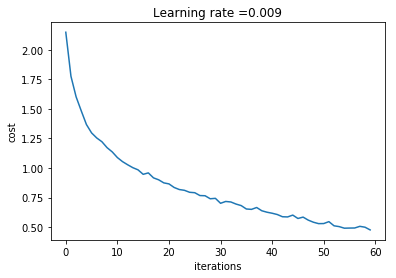

In [10]:
learning_rate = 0.009
num_epochs = 60
minibatch_size = int(X_train.shape[0]/50)
    
(m, n_H0, n_W0, n_C0) = X_train.shape                                        
costs = []         
seed = 0

X, Y = create_placeholders(32, 32, 3)
Z3 = forward_propagation(X)

cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = Z3, labels=tf.cast(Y, dtype=tf.int32)))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

init = tf.global_variables_initializer()
 
with tf.Session() as sess:
    sess.run(init)
        
    for epoch in range(num_epochs):

        minibatch_cost = 0.
        num_minibatches = int(m / minibatch_size) 
        seed = seed + 1
        minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

        for minibatch in minibatches:

            (minibatch_X, minibatch_Y) = minibatch
            _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})

            minibatch_cost += temp_cost / num_minibatches

        costs.append(minibatch_cost)

        if epoch == 0 or (epoch+1)%5 == 0:
            print("Cost after epoch %i: %f" % (epoch+1, minibatch_cost))
 
    correct_prediction = tf.equal(tf.argmax(Z3, 1), tf.cast(Y,"int64"))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print("Training Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print("Testing Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
    
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()